In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import cv2
from cv2 import imread, imshow
from scipy import spatial
import os
import time
import re
from hashlib import md5
import shutil
import itertools
import hashlib
import random
from tqdm import tqdm_notebook as tqdm
from tkinter import *
from tkinter.filedialog import askopenfilename
import tkinter as tk
from tkinter import filedialog

from pptx import Presentation
from pptx.util import Inches, Pt
import os
import re
import easygui

In [2]:
def make_dir(path):
    try:
        os.mkdir(path)
    except OSError as error:
        print('PLEASE DELETE ALREADY EXISTING FOLDER')

In [3]:
#just filtering the images, so that there are
#no Black & White images(which has 2 chanels)
#And also taking required file formats of image
def filterImage(images_arr):
    image_list = []
    unknown_image_list = []
    print('FILTERING IMAGES:')
    for image in tqdm(range(len(images_arr))):
        try:
            image_found = re.findall(".(jpg|png|JPG|PNG|jpeg)$",images_arr[image])
            if image_found:
                assert imread(images_arr[image]).shape[2] == 3
                image_list.append(images_arr[image])
            else:
                unknown_image_list.append(images_arr[image])
        except AssertionError as e:
            print(e)
    return image_list, unknown_image_list

In [4]:
#converting a colured image to gray scale image
def convertToGray(image):
    image = imread(image)
    return np.average(image, weights = [0.299,0.587,0.144], axis =2)

In [5]:
#resize the image and flattening
#the higher the number in resize is the more the pixel, you will be having precise finger prints
#If the resize is low then: then you might have too many similar images, that are actually not similar
#getting to false postivies
def imageResize(image,height=30, weight=30):
    row_res = cv2.resize(image,(height,weight), interpolation = cv2.INTER_AREA).flatten()
    col_res = cv2.resize(image,(height,weight), interpolation = cv2.INTER_AREA).flatten('F')
    return row_res, col_res

In [6]:
#Here we will find the Intensity, using gradient(change in the elemets of image vector)
#--> if there is increment in change(gradient) in postive way, then it will be one
#--> if there is decrement in chane(gradient) in negative way, the it wil be zero

def intenstiyDiff_OfImage(row_res,col_res):
    difference_row = np.diff(row_res) #taking gradient by using np.diff
    difference_col = np.diff(col_res) #it takes the difference betweeen right element and left element
    
    difference_row = difference_row > 0 #converting difference into boolean
    difference_col = difference_col > 0
    return np.vstack( (difference_row,difference_col) ).flatten()
    #we will be returnig the blue print or thumbnail(finger print) of the image

In [7]:
#getting difference in a consolidated way
def differenceScoreOfImage(image,height = 30, weight = 30):
    gray_image =  convertToGray(image)
    row_res, col_res = imageResize(gray_image,height,weight)
    difference = intenstiyDiff_OfImage(row_res, col_res)
    
    return difference

In [8]:
#Hamming dist: would calculate the percentage difference for two images
#img1: [1,0,0,0,0]
#img2: [0,0,0,0,0], hamming dist: 1/5 = 0.20 ##in this cae it is 20% dissimilar & 80% similar
# if hamming distance for two images is high --> then those images are not similar
# if hamming distance for two images is low --> then there are higher chances of both image being similar

def hammingDistance(image1,image2):
    hamming_dist_score = spatial.distance.hamming(image1,image2)#calculates the difference 
    # for two 1-D arrays
    return hamming_dist_score

In [9]:
#hamming
def differenceScoreDict(image_list):
    duplicates = []
    ds_dict = {} # difference_score_dict
    for image in image_list:
        ds = differenceScoreOfImage(image)
        ##print('Image: {0}, difference_score: {1}'.format(image,ds))
        if  image not in ds_dict:
            ds_dict[image] = ds #storing difference scores for different images(image as keys)
        else:
            duplicates.append( (image, ds_dict[image]) )
    return duplicates, ds_dict




In [10]:
def splittingDuplicatesAndOriginals(duplicates_temp,ds_dict):
    
    real_duplicate_images = []
    real_original_images = []
    
    for k1,k2 in itertools.combinations(ds_dict,2): # it gets all the non repetetive combinations, taking 
    # two elements at a time
        ##print('K1: {0}, k2: {1}'.format(k1,k2))
        if hammingDistance(ds_dict[k1], ds_dict[k2]) < .35: #best threshold values: 0.15,0.20
                                                    #tune this parameter accordingly
            duplicates_temp.append((k1,k2))
    
    duplicate_img_list = [i[0] for i in duplicates_temp]
    duplicate_img_list = list(set(duplicate_img_list)) #finding unique images in duplicate image list
    real_duplicate_images = duplicate_img_list
    
    original_img_list = [i[1] for i in duplicates_temp]
    original_img_list = list(set(original_img_list)) #finding unique images in original image list
    
    for image in original_img_list:
        if image not in duplicate_img_list:
            real_original_images.append(image)
            path = shutil.copy(image,Original_photos_path)
    
    for image in duplicate_img_list:
        path = shutil.copy(image,Duplicates_photos_path)
        
    for image in ds_dict: # if image is not similar
        if image not in duplicate_img_list:
            if image not in original_img_list:
                real_original_images.append(image) #adding non similar image to original images
                path = shutil.copy(image,Original_photos_path)
    
    return real_duplicate_images, real_original_images
    

In [11]:
#Extracting Blur Images
def blurImageFinder(original_images):
    Good_img_list = []
    Blur_img_list = []
    print('EXTRACTING BLUR IMAGES:')
    for image in tqdm( range( len( original_images ) ) ):
        cv_image = cv2.imread(original_images[image])
        laplacian_var = cv2.Laplacian(cv_image, cv2.CV_64F).var()#getting Laplacian var for each image
        if laplacian_var > 300 : # have got good edges # tune this prameter accordingly
            path = shutil.copy(original_images[image],Good_photos_path)
            Good_img_list.append(original_images[image])
        else : # if Laplacian var is less, then there is more smudge, comparitively edge detection
               # is less 
            if laplacian_var < 60:
                path = shutil.copy(original_images[image],Blur_photos_path)
                Blur_img_list.append(original_images[image])  
    return Good_img_list, Blur_img_list

In [12]:
#Extracting Duplicate Images
def duplicate_finder(image_list):
    duplicates = []
    duplicates_list = []
    originals_list = []
    hash_keys = dict()
    print('EXTRACTING DUPLICATE IMAGES:')
    for index,file_name in enumerate(tqdm( range( len(image_list)  ) ) ):
        if os.path.isfile(image_list[file_name]):
            image_found = re.findall(".(jpg|png|JPG|PNG|jpeg)$",image_list[file_name])
            if image_found:
                with open(image_list[file_name],'rb') as f:
                    file_hash = hashlib.md5(f.read()).hexdigest() #getting the hash value for the image
                    if file_hash not in hash_keys: #After hashing is hash key does'nt exist, then it's original image
                        hash_keys[file_hash] = index #index represents the image location
                        originals_list.append(image_list[file_name])
                        path = shutil.copy(image_list[file_name],Original_photos_path)
                    else: #hash key exist so, it's a duplicate
                        duplicates.append( (index,hash_keys[file_hash]) ) # hash_keys[file_hash] this will help 
                        # in getting the original image location,  (index,hash_keys[file_hash]) --> (duplicate index, orginal index)
                        duplicates_list.append(image_list[file_name])
                        path = shutil.copy(image_list[file_name],Duplicates_photos_path)
    return originals_list,duplicates_list,duplicates

In [13]:
def initialSlide(prs):
    layouts = prs.slide_layouts[0]
    slide = prs.slides.add_slide(layouts)

    titles = slide.shapes.title.text = 'Automated Photo Manager'
    sub = slide.placeholders[1].text = '    By Dinesh Reddy'
    return prs

In [14]:
def endingSlide(prs):
    layouts = prs.slide_layouts[0]
    slide = prs.slides.add_slide(layouts)

    title = slide.shapes.title.text = 'Thank You'
    prs.save('Automated_Photo_Manager.pptx')
    return prs

In [15]:
def imageSlide(prs,image_num,slide_heading):
    layouts = prs.slide_layouts[6]
    slide = prs.slides.add_slide(layouts)
    
    #dimensions for Heading
    top = Inches(0.5)
    width = Inches(6)
    height = Inches(1)
    left = Inches(3.5)
    txBox = slide.shapes.add_textbox(left, top, width, height)
    tf = txBox.text_frame
    p = tf.add_paragraph()
    p.font.bold = True
    p.text = slide_heading
    p.font.size = Pt(35)

    #dimensions for picture
    left = Inches(2.5)
    height = Inches(5)
    top = Inches(2)
    width=5
    pic = slide.shapes.add_picture(image_num,left,top,height=height)
    return prs

In [16]:
def convertToppt(prs_obj,image_type,slide_count,slide_heading):
    print("CONVERTING IMAGES TO SLIDES:")
    for image in tqdm( range( slide_count ) ):
        prs_obj = imageSlide(prs_obj,image_type[image],slide_heading)
    return prs_obj

In [17]:
#Browsing for input folder path
root = tk.Tk()
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)
folder_selected = filedialog.askdirectory(title='Please select a directory')
os.chdir(folder_selected)
os.getcwd()

'C:\\Users\\dines\\My ipython files\\Personal_Project\\Automated_Photo_Manager\\detecting-blur\\detecting-blur\\Images_Dataset\\blur-dataset\\Image_bulr&duplicates_defocused'

In [18]:
#Setting up directories
directory1 = 'Good Photos'
directory2 = 'Blur Photos'
directory3 = 'Duplicate Photos'
directory4 = 'Original Good Photos'

parent_dir = os.getcwd()
Good_photos_path = os.path.join(parent_dir,directory1)
Original_photos_path = os.path.join(parent_dir,directory4)
Blur_photos_path = os.path.join(parent_dir,directory2)
Duplicates_photos_path = os.path.join(parent_dir,directory3)

make_dir(Good_photos_path)
make_dir(Original_photos_path)
make_dir(Blur_photos_path)
make_dir(Duplicates_photos_path)


In [19]:
#Filtering Images
image_files = os.listdir()
image_list,unknown_image_list = filterImage(image_files)

#Blur image extraction
Good_img_list, Blur_img_list = blurImageFinder(image_list)

#Duplicate image extraction
Originals_list,Duplicates_list,Duplicates = duplicate_finder(Good_img_list)

#Converting Good Original images into Power Point Presenataion
prs_obj = Presentation()
prs_obj = initialSlide(prs_obj)
prs_obj = convertToppt(prs_obj,Originals_list,30,'Good Photos')
prs_obj = convertToppt(prs_obj,Blur_img_list,10,'BLur Photos')
prs_obj = endingSlide(prs_obj)

FILTERING IMAGES:



EXTRACTING BLUR IMAGES:



EXTRACTING DUPLICATE IMAGES:



CONVERTING IMAGES TO SLIDES:



CONVERTING IMAGES TO SLIDES:


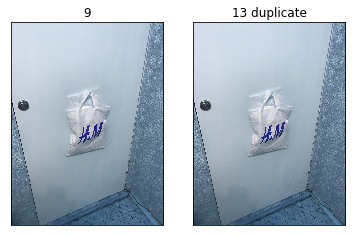

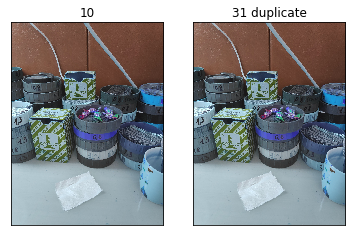

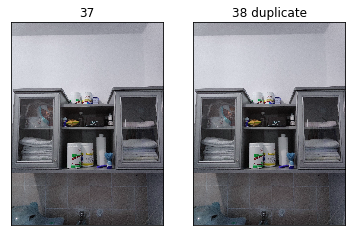

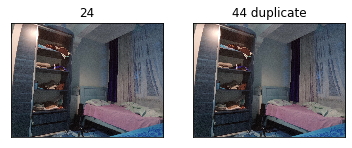

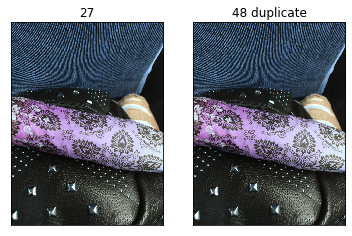

In [23]:
#plotting the duplicate images with original images
for file_indexes in Duplicates[:5]:
    try:
    
        plt.subplot(121),plt.imshow(imread(Good_img_list[file_indexes[1]]))
        plt.title(file_indexes[1]), plt.xticks([]), plt.yticks([])

        plt.subplot(122),plt.imshow(imread(Good_img_list[file_indexes[0]]))
        plt.title(str(file_indexes[0]) + ' duplicate'), plt.xticks([]), plt.yticks([])
        plt.show()
    
    except OSError as e:
        continue